In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.patches import Ellipse

import numpy as np
from scipy.special import erfcinv
import scipy.stats as st
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfcinv, erfinv, erf, erfc
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os


import numpy as np
from scipy.linalg import sqrtm
from getdist import plots
from getdist.mcsamples import MCSamples
from scipy.special import erfcinv
from scipy.stats import gamma
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vectors
n_samples = int(1e6)

# 2) setear la familia correcta y opciones PRL

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif"],
    "mathtext.fontset": "cm",   # símbolos math tipo Computer Modern
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

})

# 3) verificación rápida
#print("Found:", fm.findfont("TeXGyreTermes"))


# --- Constantes PRL (una columna) ---
PRL_COL_W = 3.37  # inches ~ 8.6 cm
SIZE_LABEL = 9
SIZE_TICK  = 9
SIZE_LEG   = 9
LW         = 0.8  # line width fino PRL
QUIVER_W   = 0.006  # ancho de flecha (en pulgadas aprox.)

# ---- Contexto de estilo local (no afecta global) ----
rc = {
    "font.size": SIZE_TICK,
    "axes.titlesize": SIZE_LABEL,
    "axes.labelsize": SIZE_LABEL,
    "xtick.labelsize": SIZE_TICK,
    "ytick.labelsize": SIZE_TICK,
    "legend.fontsize": SIZE_LEG,
    "lines.linewidth": LW,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,  # para fuentes embebibles
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif"],
}

Path to git repo: /home/matias/Documents/PhD/code


# PTE to $N_{\sigma}$

Que es $N_{\sigma}^{eff}$? Hagamos algunos graficos

In [2]:
import numpy as np
from math import erf, sqrt
from scipy.stats import chi2

def L_iso_from_n(d: int, n: float, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Distancia euclídea L entre las medias de dos Gaussianas D-dimensionales
    idénticas e isotrópicas (Sigma = sigma2 * I), tal que sus contornos 
    que en 1D corresponden a ±nσ se 'toquen'.

    Parámetros
    ----------
    d : int
        Dimensión (D).
    n : float
        'Número de sigmas' 1D (es decir, p = erf(n / sqrt(2))).
    sigma2 : float, opcional
        Varianza isotrópica por eje (default 0.5).

    Devuelve
    --------
    L : float
        Distancia euclídea entre medias.
    """


    if gauss_scale == '1sigma':
        # Probabilidad 1D asociada a ±nσ
        p = erf(n / sqrt(2.0)) #is the same, less general
        #p = chi2.cdf(n**2, df=1)  # Cumulative distribution function for chi2Q
    elif gauss_scale == '2sigma':
        p = chi2.cdf(n**2, df=2)  # Cumulative distribution function for chi2

    # Cuantil chi-cuadrado con d grados de libertad
    m2 = chi2.ppf(p, df=d)              # m^2 = χ²_{d,p}
    m  = sqrt(m2)
    # En isotrópico: L = 2 * σ * m, con σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m

print('--- Using 1sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n))   # d=2, sigma^2=0.5

print('--- Using 2sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n, gauss_scale='2sigma'))   # d=2, sigma^2=0.5

--- Using 1sigma scale ---
1 2.142778070122352
2 3.515700301858557
3 4.863981513513553
4 6.21834521588094
5 7.5820448992254725
--- Using 2sigma scale ---
1 1.4142135623730951
2 2.8284271247461903
3 4.242640687119287
4 5.656854249492375
5 7.071067811867373


# $N_\sigma^{eff}(N_\sigma)$ and $L(N_\sigma)$

# Three moltivariate distributions

In [3]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

In [4]:
#Define some functions:

def construct_C(vectors):
    L = len(vectors)

    K_xx = np.sum((vectors[:, 0]) ** 2)
    K_yy = np.sum((vectors[:, 1]) ** 2)
    K_xy = np.sum((vectors[:, 0]) * (vectors[:, 1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

# Real Data

In [5]:
import git
import sys, os

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

'''
os.chdir(os.path.join(path_global,'montepython_public_old','output'))   

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples .loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})
'''




os.chdir(os.path.join(path_global,'Cobaya','output','cluster','lcdm'))

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/lcdm_cc', no_cache=True,settings={'loglikes':True,'names':'CC','label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/lcdm_planck', no_cache=True,settings={'loglikes':True,'names':'Planck18','label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_desi_dr2/lcdm_desi_dr2', no_cache=True,settings={'loglikes':True,'names':'DESI DR2','label':'DESI DR2','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/lcdm_pps', no_cache=True,settings={'names':'PPS','label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared paameters
names = param_names
labels = ['\Omega_m','H_0']

#Estimate the mean and covariance of the chains:
mean_A_0 = chain_A.mean(param_names)
mean_B_0 = chain_B.mean(param_names)
mean_C_0 = chain_C.mean(param_names)
mean_D_0 = chain_D.mean(param_names)

cov_A_0 = chain_A.cov(param_names)
cov_B_0 = chain_B.cov(param_names)
cov_C_0 = chain_C.cov(param_names)
cov_D_0 = chain_D.cov(param_names)

In [6]:
os.chdir(os.path.join(path_git,'notebooks','paper_plots'))
dark_violet = '#4B0082'

In [7]:
def plot_geom_panel(ax,
                    mean_A, mean_B, mean_C,
                    cov_A, cov_B, cov_C,
                    text_title,
                    edge_labels,
                    label_shifts=None):
    """
    label_shifts: dict opcional { 'AB': (dx, dy), 'BC': (dx, dy), ..., 'v1': (dx, dy), 'v2': (dx, dy) }
                  dx, dy se interpretan en unidades de base_range y se suman a la punta de la flecha.
    """

    # --- Tensores de tensión r_k ---
    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_4 = -r_1
    r_5 = -r_2
    r_6 = -r_3

    R = np.vstack([r_1, r_2, r_3, r_4, r_5, r_6])

    # --- C_tot y espectro ---
    C_tot = construct_C(R)
    evals, evecs = np.linalg.eigh(C_tot)
    idx = np.argsort(evals)[::-1]
    lam1, lam2 = evals[idx[0]], evals[idx[1]]
    v1 = evecs[:, idx[0]]
    v2 = evecs[:, idx[1]]

    ax.set_xlabel(r'$\Delta \Omega_m$')
    ax.set_ylabel(r'$\Delta H_0$')

    # Flechas de tensión
    for r in (r_1, r_2, r_3, r_4, r_5, r_6):
        ax.quiver(0, 0, r[0], r[1], angles='xy', scale_units='xy', scale=1,
                  color=dark_violet, width=QUIVER_W, alpha=0.9)

    # Origen
    ax.scatter([0], [0], color='black', s=8)

    # Autovectores
    ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1,
              color='black', width=QUIVER_W)
    ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1,
              color='black', width=QUIVER_W)

    # ---------- 1) escala típica ----------
    base_range = np.max(np.abs(R)) if np.isfinite(R).all() else 1.0

    # helper: posición del label a partir de la punta de la flecha
    def compute_label_pos(r, text):
        """
        r: vector (punta de la flecha)
        text: string del label, usado para buscar shift manual si existe
        """
        # shift manual desde afuera, en unidades de base_range:
        if (label_shifts is not None) and (text in label_shifts):
            dx, dy = label_shifts[text]
            return np.array([r[0] + dx * base_range, r[1] + dy * base_range])

        # si no hay shift manual, usar lógica automática (signo + pequeño empuje interior)
        offset = 0.06 * base_range
        inner_shift = 0.05 * base_range

        sx = 1 if r[0] >= 0 else -1
        sy = 1 if r[1] >= 0 else -1

        pos = np.array([r[0] + sx * offset, r[1] + sy * offset])
        pos[0] -= sx * inner_shift
        pos[1] -= sy * inner_shift
        return pos

    # ---------- 2) calculamos TODAS las posiciones de labels ----------
    l1, l2, l3, l4, l5, l6 = edge_labels

    lp_r1 = compute_label_pos(r_1, l1)
    lp_r2 = compute_label_pos(r_2, l2)
    lp_r3 = compute_label_pos(r_3, l3)
    lp_r4 = compute_label_pos(r_4, l4)
    lp_r5 = compute_label_pos(r_5, l5)
    lp_r6 = compute_label_pos(r_6, l6)

    lp_v1 = compute_label_pos(v1, 'v1')
    lp_v2 = compute_label_pos(v2, 'v2')

    # puntos relevantes (flechas + labels + origen)
    all_points = np.vstack([
        R,
        lp_r1, lp_r2, lp_r3, lp_r4, lp_r5, lp_r6,
        v1, v2,
        np.array([0.0, 0.0])
    ])

    max_x = np.max(np.abs(all_points[:, 0]))
    max_y = np.max(np.abs(all_points[:, 1]))
    max_range_loc = max(max_x, max_y)

    pad = 0.10 * max_range_loc  # pequeño margen extra
    lim_x = (-max_range_loc - pad, max_range_loc + pad)
    lim_y = (-max_range_loc - pad, max_range_loc + pad)

    # ---------- 3) dibujamos las labels ----------
    def label_at_vector(ax_, pos, text, color='black'):
        ax_.text(pos[0], pos[1], text,
                 size=SIZE_LEG-3, color=color)

    # v1 / v2
    label_at_vector(ax, lp_v1, 'v1', color='black')
    label_at_vector(ax, lp_v2, 'v2', color='black')

    label_at_vector(ax, lp_r1, l1, color=dark_violet)
    label_at_vector(ax, lp_r2, l2, color=dark_violet)
    label_at_vector(ax, lp_r3, l3, color=dark_violet)
    label_at_vector(ax, lp_r4, l4, color=dark_violet)
    label_at_vector(ax, lp_r5, l5, color=dark_violet)
    label_at_vector(ax, lp_r6, l6, color=dark_violet)

    # ---------- 4) Eccentricidad y cuadro ----------
    lam_min = float(np.min(evals))
    lam_max = float(np.max(evals))
    ecc = np.sqrt(max(0.0, 1.0 - (lam_min/lam_max if lam_max > 0 else 0.0)))

    info_text = (
        rf"$\lambda_1 = {lam1:.3g}$" "\n"
        rf"$\lambda_2 = {lam2:.3g}$" "\n"
        rf"$\mathrm{{Ecc}} = {ecc:.3g}$"
    )

    ax.text(
        0.98, 0.02, info_text,
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=SIZE_LEG,
        bbox=dict(boxstyle='round,pad=0.25', facecolor='white',
                  alpha=0.9, edgecolor='black', linewidth=LW)
    )

    # ---------- 5) límites, aspecto, grilla, título ----------
    ax.set_xlim(*lim_x)
    ax.set_ylim(*lim_y)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.25, linewidth=LW*0.8)

    ax.text(
        0.02, 0.98, text_title,
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=SIZE_LEG-2,
        bbox=dict(boxstyle='round,pad=0.25', facecolor='white',
                  alpha=0.9, edgecolor='black', linewidth=LW)
    )


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


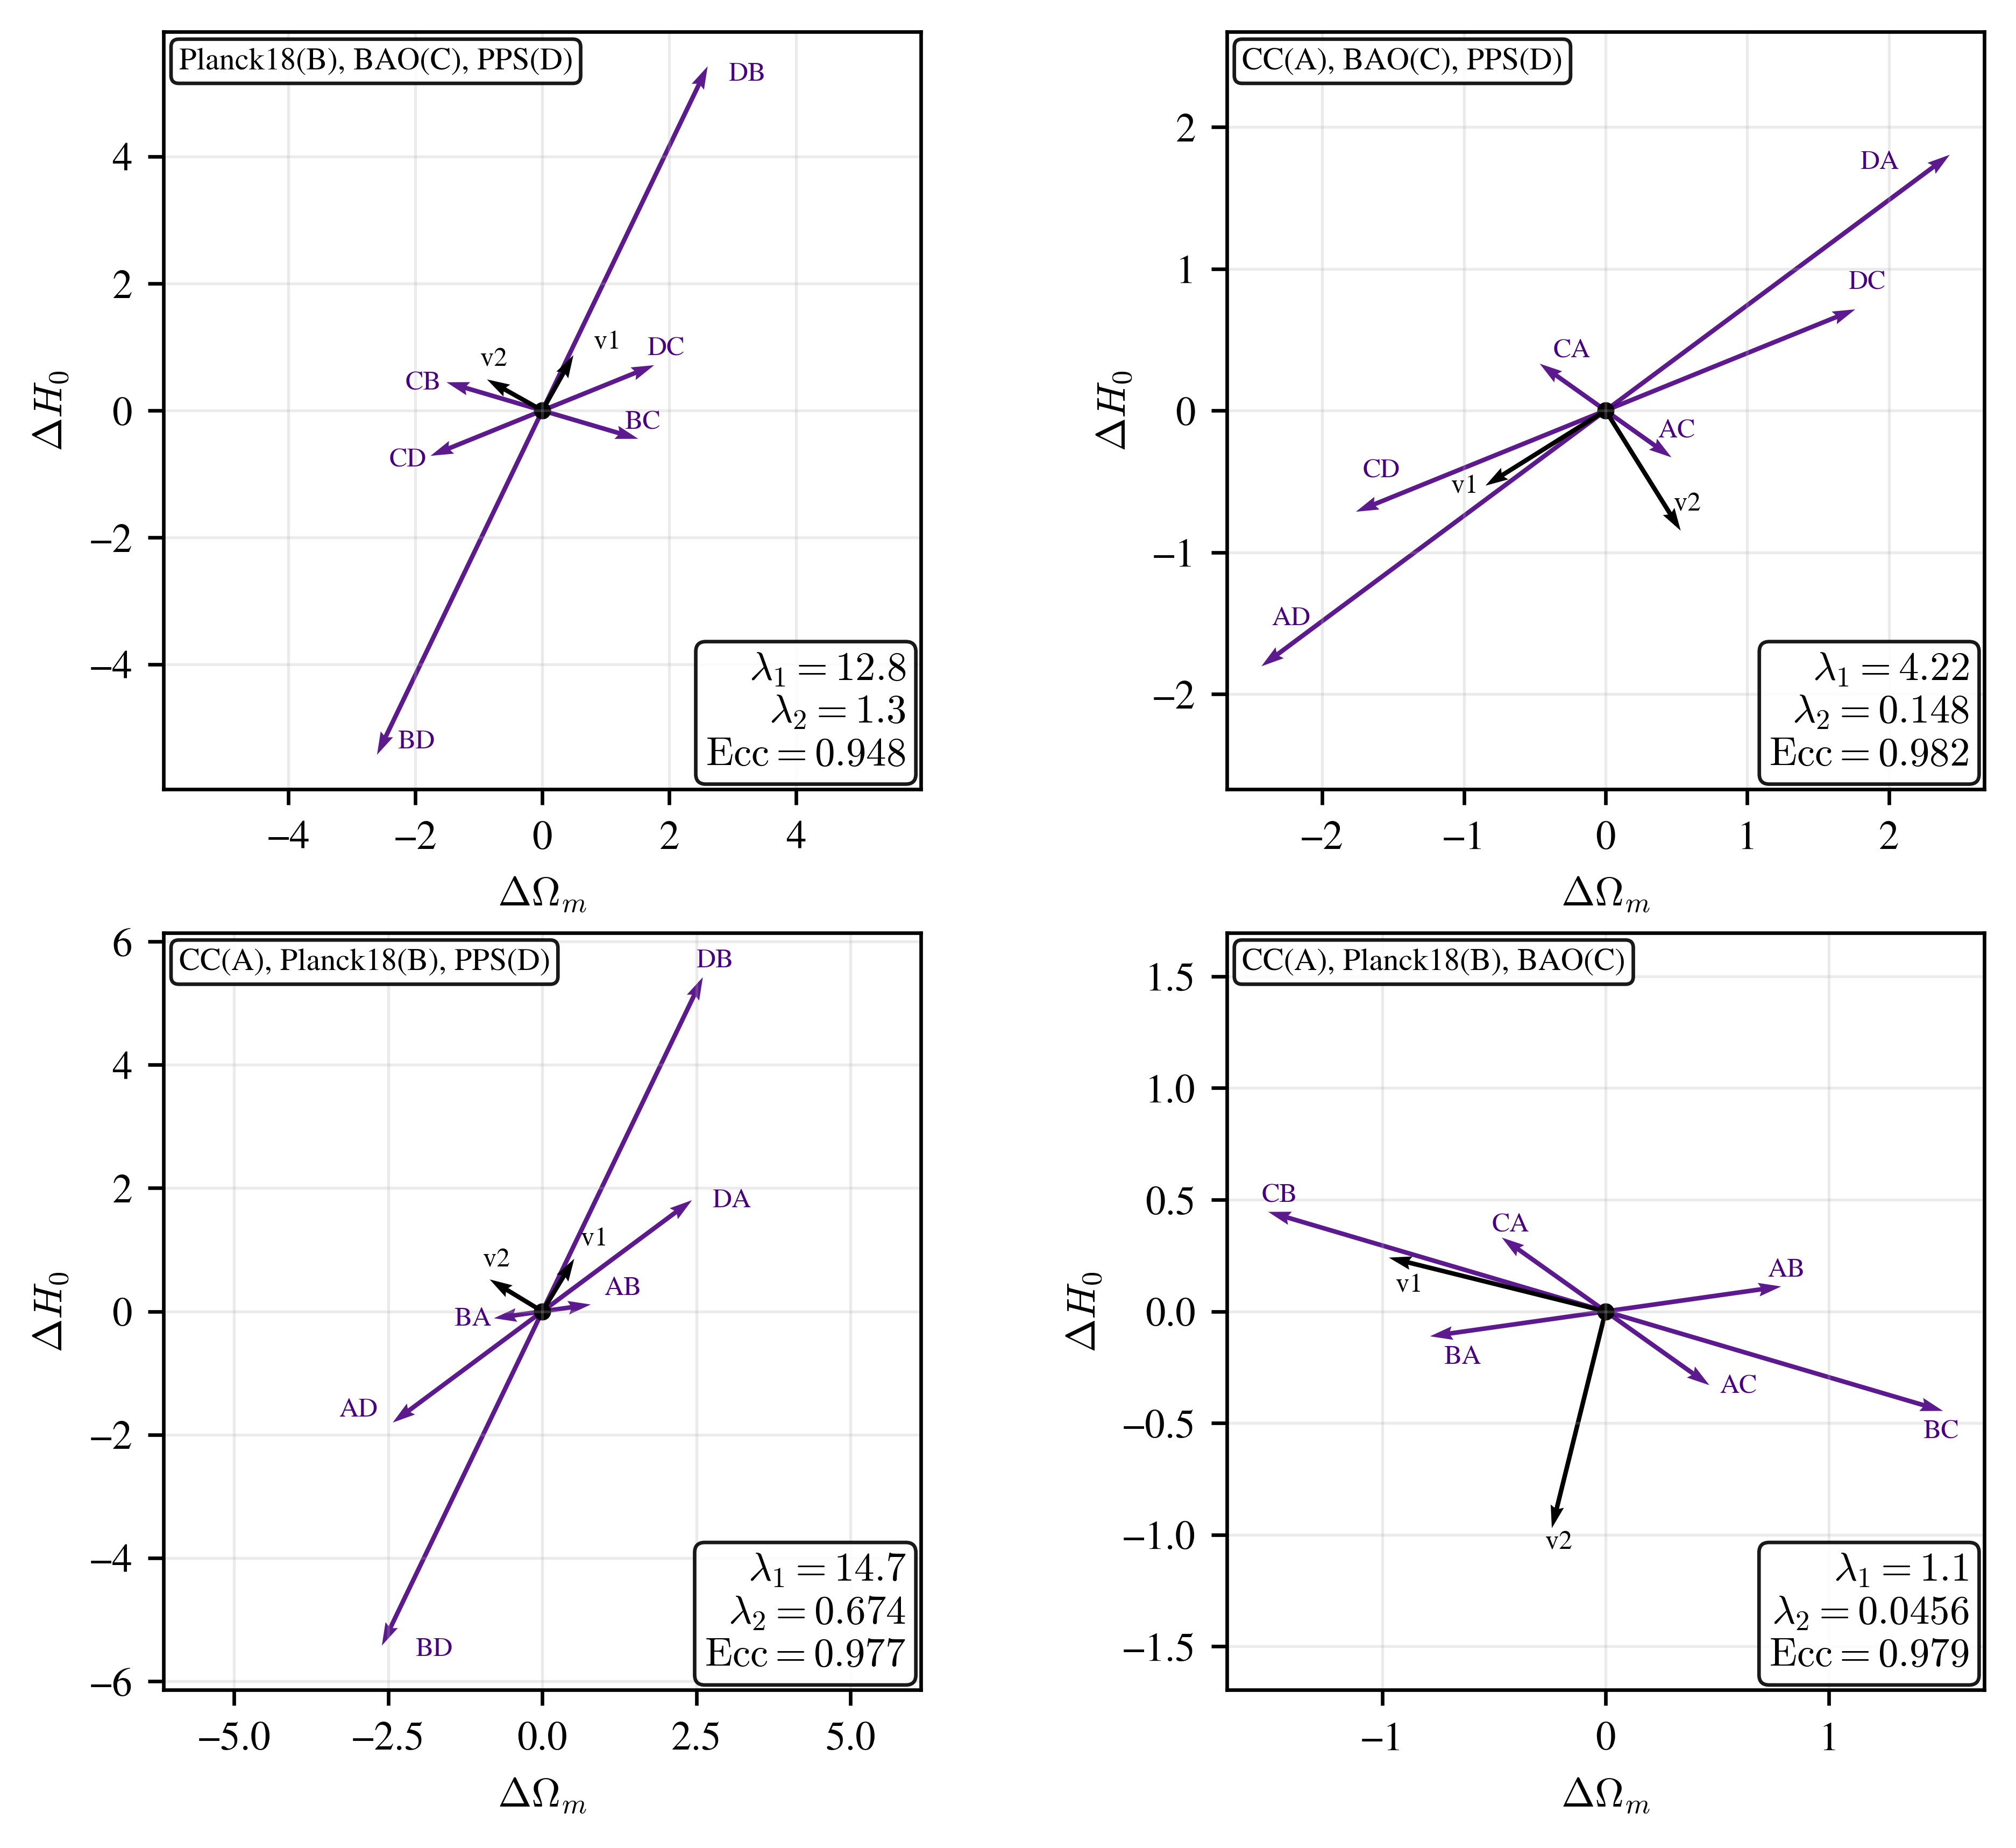

In [8]:

# =======================================================================
# Definimos los 4 casos como una lista de configs
# =======================================================================

configs = [
    dict(   # without_cc
        text_title='Planck18(B), BAO(C), PPS(D)',
        name_plot='without_cc',
        mean_A=mean_B_0, cov_A=cov_B_0,   # B
        mean_B=mean_C_0, cov_B=cov_C_0,   # C
        mean_C=mean_D_0, cov_C=cov_D_0,   # D
        edge_labels=('BC', 'BD', 'CD', 'CB', 'DB', 'DC'),
        label_shifts={
            'BC': (-0.04,  0.03),
            'BD': ( 0.06,  0.02),
            'CD': (-0.12, -0.03),
            'CB': (-0.12, -0.02),
            'DB': ( 0.06, -0.04),
            'DC': (-0.02,  0.03),
            'v1': ( 0.06,  0.02),
            'v2': (-0.02,  0.04),
        },
    ),
    dict(   # without_planck
        text_title='CC(A), BAO(C), PPS(D)',
        name_plot='without_planck',
        mean_A=mean_A_0, cov_A=cov_A_0,   # A
        mean_B=mean_C_0, cov_B=cov_C_0,   # C
        mean_C=mean_D_0, cov_C=cov_D_0,   # D
        edge_labels=('AC', 'AD', 'CD', 'CA', 'DA', 'DC'),
        label_shifts={
            'AC': (-0.04,  0.06),
            'AD': ( 0.03,  0.12),
            'CD': ( 0.02,  0.10),
            'CA': ( 0.04,  0.02),
            'DA': (-0.26, -0.04),
            'DC': (-0.02,  0.06),
            'v1': (-0.10, -0.02),
            'v2': (-0.02,  0.06),
        },
    ),
    dict(   # without_BAO
        text_title='CC(A), Planck18(B), PPS(D)',
        name_plot='without_BAO',
        mean_A=mean_A_0, cov_A=cov_A_0,   # A
        mean_B=mean_B_0, cov_B=cov_B_0,   # B
        mean_C=mean_D_0, cov_C=cov_D_0,   # D
        edge_labels=('AB', 'AD', 'BD', 'BA', 'DA', 'DB'),
        label_shifts={
            'AB': ( 0.04,  0.03),
            'AD': (-0.16,  0.02),
            'BD': ( 0.10, -0.03),
            'BA': (-0.12, -0.02),
            'DA': ( 0.06, -0.02),
            'DB': (-0.02,  0.03),
            'v1': ( 0.02,  0.04),
            'v2': (-0.02,  0.04),
        },
    ),
    dict(   # without_PPS
        text_title='CC(A), Planck18(B), BAO(C)',
        name_plot='without_PPS',
        mean_A=mean_A_0, cov_A=cov_A_0,   # A
        mean_B=mean_B_0, cov_B=cov_B_0,   # B
        mean_C=mean_C_0, cov_C=cov_C_0,   # C
        edge_labels=('AB', 'AC', 'BC', 'BA', 'CA', 'CB'),
        label_shifts={
            'AB': (-0.04,  0.03),
            'AC': ( 0.03, -0.02),
            'BC': (-0.06, -0.08),
            'BA': ( 0.04, -0.08),
            'CA': (-0.03,  0.02),
            'CB': (-0.02,  0.03),
            'v1': ( 0.02, -0.10),
            'v2': (-0.02, -0.06),
        },
    ),
]

# =======================================================================
# (Opcional) calcular un max_range global para que los 4 paneles
# tengan exactamente la misma escala en x/y
# =======================================================================

#all_R = []
for cfg in configs:
    mean_A = cfg['mean_A']; mean_B = cfg['mean_B']; mean_C = cfg['mean_C']
    cov_A  = cfg['cov_A'];  cov_B  = cfg['cov_B'];  cov_C  = cfg['cov_C']

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_4 = -r_1
    r_5 = -r_2
    r_6 = -r_3
    R = np.vstack([r_1, r_2, r_3, r_4, r_5, r_6])
    #all_R.append(R)

#global_max_range = max(np.max(np.abs(R)) for R in all_R if np.isfinite(R).all())

# =======================================================================
# Figura 2x2
# =======================================================================

with mpl.rc_context(rc):
    fig_w, fig_h = 2 * PRL_COL_W, 2 * 2.8  # 2 columnas x 2 filas
    fig, axes = plt.subplots(2, 2, figsize=(fig_w, fig_h))

    axes = axes.ravel()
    for ax, cfg in zip(axes, configs):
        plot_geom_panel(
            ax,
            mean_A=cfg['mean_A'], mean_B=cfg['mean_B'], mean_C=cfg['mean_C'],
            cov_A=cfg['cov_A'],   cov_B=cfg['cov_B'],   cov_C=cfg['cov_C'],
            text_title=cfg['text_title'],
            edge_labels=cfg['edge_labels'],
            label_shifts=cfg.get('label_shifts', None)
            #max_range=global_max_range,   # así todos mismo zoom
        )

    fig.tight_layout(pad=0.3)
    os.chdir(os.path.join(path_global,'multimeter','notebooks','paper_plots','figures'))
    fig.savefig('geom_all_2x2.pdf')   # una sola figura con 4 paneles
    fig.savefig('geom_all_2x2.svg')
    fig.savefig('geom_all_2x2.png', dpi=300)
    plt.show()